<a href="https://colab.research.google.com/github/Ttemnaya/model_met/blob/main/%D0%93%D0%BE%D1%82%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BF%D0%BE_%D1%86%D0%B5%D0%BD%D0%B5_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Прогноз цен

*Алгоритм работы:*

1) **Используемые библиотеки**

2) **Создание дополнительных классов**, (метрики, решетчатый метод подбора параметров, расширение исходной таблицы, кор. матрица, формирования таблиц для обучения моделей)

3) **Подработка данных**
1. Удаление нулевых значений, изменение формата данных для расчетов, расширение данных
2. Отбор влияющих факторов, корреляция и сортировка

4) **Обучение моделей**
1. XGBoost модель
2. Вектор Шепли

5) **Прогноз**
1. Формирование таблицы для предикта
2. Прогноз
3. Формирование итоговой таблицы (восстановление первоначальных форматов, сокращение столбцов)

6) **Итоговая таблица**




# Дополнительная теория


1) **Гиперпараметры** — это характеристики модели, которые фиксируются до начала
обучения: глубина решающего дерева, значение силы регуляризации в линейной модели, learning rate для градиентного спуска.

**GridSearchCV**

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке (Grid Search):

*  для каждого гиперпараметра фиксируется несколько значений;
*  перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
*  выбирается комбинация, на которой модель показывает лучшее качество.

(Random Search – иной способ подбора, для каждого гиперпараметра задаётся распределение, из которого выбирается его значение, и комбинация гиперпараметров составляется семплированием из этих распределений).

2)	**Взаимодействие факторов:**

Факторы взаимодействуют друг с другом в процессе подготовки данных и обучения модели, через методы класса ColumnHandler:

Каждый метод класса ColumnHandler представляет собой операцию агрегации данных по определенным категориям или условиям.

Пример: Например, метод mean_price() создает новый признак "Mean_PRICE", который представляет собой среднее значение цены для каждой категории "MARKA".

Обработка нулевых и неполных данных: используем методы класса ColumnHandler, чтобы заполнить пропущенные значения средними значениями по группам. Это позволило уменьшить влияние нулевых или неполных данных на процесс обучения модели.

3)	**Модели прогнозирования: XGBoost**

В коде используется экстремальный бустинг для построения модели прогнозирования. Мы создаем экземпляр модели, указывая оптимальные гипперпараметры, найденные с помощью решетчатого поиска (GridSearchCV).

Затем модель обучается на обучающих данных с помощью метода fit(), а затем используется для предсказания на тестовых данных с помощью метода predict(). После этого оценивается качество модели с помощью метрик, таких как коэффициент детерминации (R^2 score), среднеквадратичная ошибка (MSE) и RMSE.

Экстремальный бустинг выбран из-за его высокой производительности и эффективности в решении задач регрессии. Он хорошо подходит для работы с большими объемами данных и способен обрабатывать различные типы признаков. Также он имеет встроенную поддержку решетчатого поиска для оптимизации гиперпараметров.

В коде используются следующие коэффициенты для экстремального бустинга: learning_rate, max_depth, n_estimators и random_state.

4)	**Вектор шелпи (Shapley values)**

является методом объяснения предсказаний модели машинного обучения. Он используется для оценки вклада каждого признака в прогноз модели. В регрессионных моделях прогноза вектор шелпи может быть полезен для понимания того, какие признаки оказывают наибольшее влияние на прогнозы модели.
Преимущества использования вектора шелпи в регрессионных моделях:

*   Интерпретируемость: Вектор шелпи позволяет интерпретировать причину прогнозов модели, показывая важность каждого признака для конкретного предсказания.
*  Отслеживание изменений: При изменении значений признаков можно использовать вектор шелпи для понимания, как изменится прогноз модели.
*  Помощь в принятии решений: Анализ вектора шелпи может помочь принять решения на основе важности различных признаков.






# Используемые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sns
%pip install shap
import shap
from pandas import read_csv, DataFrame

from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
from matplotlib import pyplot
pd.options.display.float_format ='{:,.3f}'.format
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from typing import Dict, Any, List

pd.options.display.float_format ='{:,.3f}'.format
warnings.filterwarnings("ignore")
%pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.6 MB/s eta 0:00:00


# Классы


In [ ]:
#Метрики
def my_result(y_test: List[float], y_pred: List[float], title: str) -> None:
    # Оценка качества модели на тестовой выборке
    print(f"R^2 score: {r2_score(y_test, y_pred)}")

    # Расчет MSE и RMSE на тестовой выборке
    print("MSE на тестовой выборке:", mean_squared_error(y_test, y_pred))
    print("RMSE на тестовой выборке:", mean_squared_error(y_test, y_pred, squared=False))

    # Расчет MAE
    mae = mean_absolute_error(y_test, y_pred)
    print("MAE на тестовой выборке:", mae)

    # Расчет MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print("MAPE на тестовой выборке:", mape)

    # Расчет WAPE
    wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test) * 100
    print("WAPE на тестовой выборке:", wape)

    # Расчет SMAPE
    smape = 2 * np.mean(np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred))) * 100
    print("SMAPE на тестовой выборке:", smape)

    # визуализация прогноза модели
    plt.scatter(y_test, y_pred)
    plt.plot([2014, max(y_test)], [2014, max(y_pred)], 'k--', lw=2)
    plt.ylabel('Реальные значения')
    plt.xlabel('Предсказанные значения')
    plt.title(title)
    plt.show()

In [ ]:
# Решетчатый метод
def find_best_params(X_train: Any, y_train: Any, random_seed: int) -> Dict[str, Any]:
    # задаем параметры для поиска по сетке
    param_grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
                  'max_depth': [2, 3, 4],
                  'n_estimators': list(range(10, 200, 10)),
                  'random_state': [random_seed]}
    # создаем модель
    gb_model = GradientBoostingRegressor()

    # создаем объект GridSearchCV для поиска по сетке
    grid_search = GridSearchCV(gb_model, param_grid, cv=5)

    # обучаем модель
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_

In [ ]:
# Расширение таблицы для обучения
class ColumnHandler:
    def __init__(self, df):
        self.df = df

    def mean_macca(self):
        self.df['Mean_MACCA'] = self.df.groupby('MARKA')['MACCA'].transform('mean')

    def presence_of_nikel(self):
        self.df['presence_of_nikel'] = self.df['TIP_KAT'].apply(lambda x: 1 if 'Ni' in x else 0)

    def mean_macca_per_data_coct_tipkat(self):
        self.df['mean_macca_per_data_coct_tipkat'] = self.df.groupby(['TIP_KAT', 'COCTOYANIE', 'DATA'])['MACCA'].transform('mean')

    def update_with_peregruska_data(self):
        self.df['DATA_PERIOD_DIFF'] = self.df['DATA'] - self.df['PERIOD']
        self.df['PEREGRUSKA_PERIOD_RATIO'] = self.df['PEREGRUSKA'] / self.df['PERIOD']
        self.df['DATA_PERIOD_MEAN_MACCA'] = self.df.groupby(['DATA', 'PERIOD'])['MACCA'].transform('mean')
        self.df['PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA'] = self.df['PEREGRUSKA'].astype(int) * self.df['DATA'] * self.df['PERIOD']

# Декоратор для обработки столбцов
def column_handler_decorator(func: Any) -> Any:
    def wrapper(*args: Any, **kwargs: Any) -> pd.DataFrame:
        """
        Args:
            *args: Any
            **kwargs: Any
        Returns:
            pd.DataFrame
        """
        df = kwargs.get('df', args[0].copy())  # Получаем DataFrame из kwargs или из первого позиционного аргумента
        ch = ColumnHandler(df)
        for method_name in dir(ch):
            if method_name.startswith('mean_') or method_name.startswith('presence_of_') or method_name.startswith('update_'):
                method = getattr(ch, method_name)
                method()
        return ch.df
    return wrapper


@column_handler_decorator
def process_dataframe(ch: Any) -> None:
    pass


In [ ]:
# Функция для расчета важности признаков
def show_feature_importances(model: RandomForestRegressor, features: List[str]) -> pd.DataFrame:
    plt.figure(figsize=(12, 8))

    # Создадим датафрейм фич и их важностей и отсортируем его
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending=False)

    # Отображение
    print(results.head(10))
    print('n Признаков с важностью выше 0.01 = ', np.sum(results['importance'] > 0.01))

    # График
    results.head(20).plot(x='feature', y='importance', kind='barh',
                          color='red', edgecolor='k', title='Feature Importances')
    return results

In [ ]:
# Матрица корреляции
class MatrixCorrelation:
    def __init__(self, processed_df: pd.DataFrame) -> None:
        self.processed_df = processed_df

    def matrix(self) -> pd.DataFrame:
        correlation = self.processed_df.corr()
        return correlation

    def graph(self) -> None:
        correlation = self.matrix()
        plt.figure(figsize=(20, 15))
        sns.heatmap(correlation, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()


In [ ]:
class EmptyPriceTableGenerator:
    def __init__(self, df):
        self.df = df
        # Remove the 'PRICE' column
        self.df = self.df.drop(columns=['PRICE'])

    def generate_empty_price_table(self):
        empty_price_table = pd.DataFrame()  # Initialize an empty DataFrame

        # Group by 'MARKA', 'MACCA', and 'USTANOVKA' and duplicate each row 10 times with incremented date
        for _, group in self.df.groupby(['MARKA', 'MACCA', 'USTANOVKA']):
            # Duplicate each row 10 times with incremented date
            for i in range(1, 11):
                duplicate_rows = group.copy()  # Create a copy of the group
                duplicate_rows['DATA'] += i
                empty_price_table = pd.concat([empty_price_table, duplicate_rows])

        return empty_price_table

# Подработка данных



1.


In [ ]:
df = pd.read_excel('ichod.xlsx')
DF = process_dataframe(df)
DF.sort_index(ascending=True)
DF['PERIOD'] /= 12
with pd.option_context('display.max_columns', None):
    display(DF)

,DATA,POTREBITEL,NPS,USTANOVKA,TIP_KAT,F,MARKA,CLOI,PROISVOD,MACCA,PERIOD,COCTOYANIE,PRICE,PEREGRUSKA,GRUPA PERIODA,COCTAV,GRUPA MACCA,Mean_MACCA,mean_macca_per_data_coct_tipkat,presence_of_nikel,DATA_PERIOD_DIFF,PEREGRUSKA_PERIOD_RATIO,DATA_PERIOD_MEAN_MACCA,PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA
0,2013,Группа Газпром,САЛАВАТ,УСГБ,CoNiMo,VGO HDT,HR 544,Base,AXENS,19.200,2.000,1,13.800,2015,24,3,20,44.960,19.200,1,1989,83.958,10.667,97348680
1,2013,Группа Газпром,САЛАВАТ,УСГБ,CoMo,Diesel HDT,HR 806,Base,AXENS,8.400,2.000,1,22.900,2015,24,2,9,10.200,8.400,0,1989,83.958,10.667,97348680
2,2013,Группа Газпром,САЛАВАТ,УСГБ,NiMo,VGO HDT,HR 841,Base,AXENS,4.400,2.000,1,26.300,2015,24,2,5,11.800,4.400,1,1989,83.958,10.667,97348680
3,2014,Группа Газпром,АСТРАХАНСКИЙ,У 1.732 (тит. 203),CoMo,Diesel HDT,HR 626,Base,AXENS,32.000,6.000,1,13.500,2020,72,2,33,104.867,73.467,0,1942,28.056,13.200,292916160
4,2014,Группа Газпром,АСТРАХАНСКИЙ,У 1.734 Л 35 11/1000,NiMo,saturation,ACT 935,Grading,AXENS,0.800,6.000,1,16.600,2020,72,2,1,5.393,7.467,1,1942,28.056,13.200,292916160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2023,Группа Газпром,САЛАВАТ,Л 16 1 (2),CoNiMo,VGO HDT,HR 544,Base,AXENS,34.400,3.000,0,7.500,2026,48,3,35,44.960,34.400,1,1987,56.278,48.083,147549528
218,2023,ЛУКОЙЛ,ВОЛГОГРАДСКИЙ,Prime D,NiMo,Si trap,TK 453,Grading,HALDOR TOPSOE,3.300,2.000,1,14.100,2025,24,2,4,3.300,2.475,1,1999,84.375,121.325,98317800
219,2023,ЛУКОЙЛ,ВОЛГОГРАДСКИЙ,Prime D,CoMo,Diesel HDT,TK 578,Base,HALDOR TOPSOE,315.300,2.000,0,11.700,2025,24,2,316,177.907,240.450,0,1999,84.375,121.325,98317800
220,2023,ЛУКОЙЛ,ВОЛГОГРАДСКИЙ,Prime D,NiMo,HDM/HDS,TK 743,Grading,HALDOR TOPSOE,1.100,2.000,1,14.500,2025,24,2,2,6.464,2.475,1,1999,84.375,121.325,98317800


In [ ]:
#копия необходима для легенды в Шепли
DF_copy = DF.copy()
X2 = DF_copy.drop(columns=['PRICE'])
y2 = DF_copy['PRICE']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=70)
X_test2.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
text_categor_cols = ['POTREBITEL', 'NPS', 'USTANOVKA', 'TIP_KAT',
                     'F', 'MARKA', 'CLOI', 'PROISVOD']
label_encoders = {}
for col in text_categor_cols:
    le = LabelEncoder()
    DF[col] = le.fit_transform(DF[col])
    label_encoders[col] = le

2.

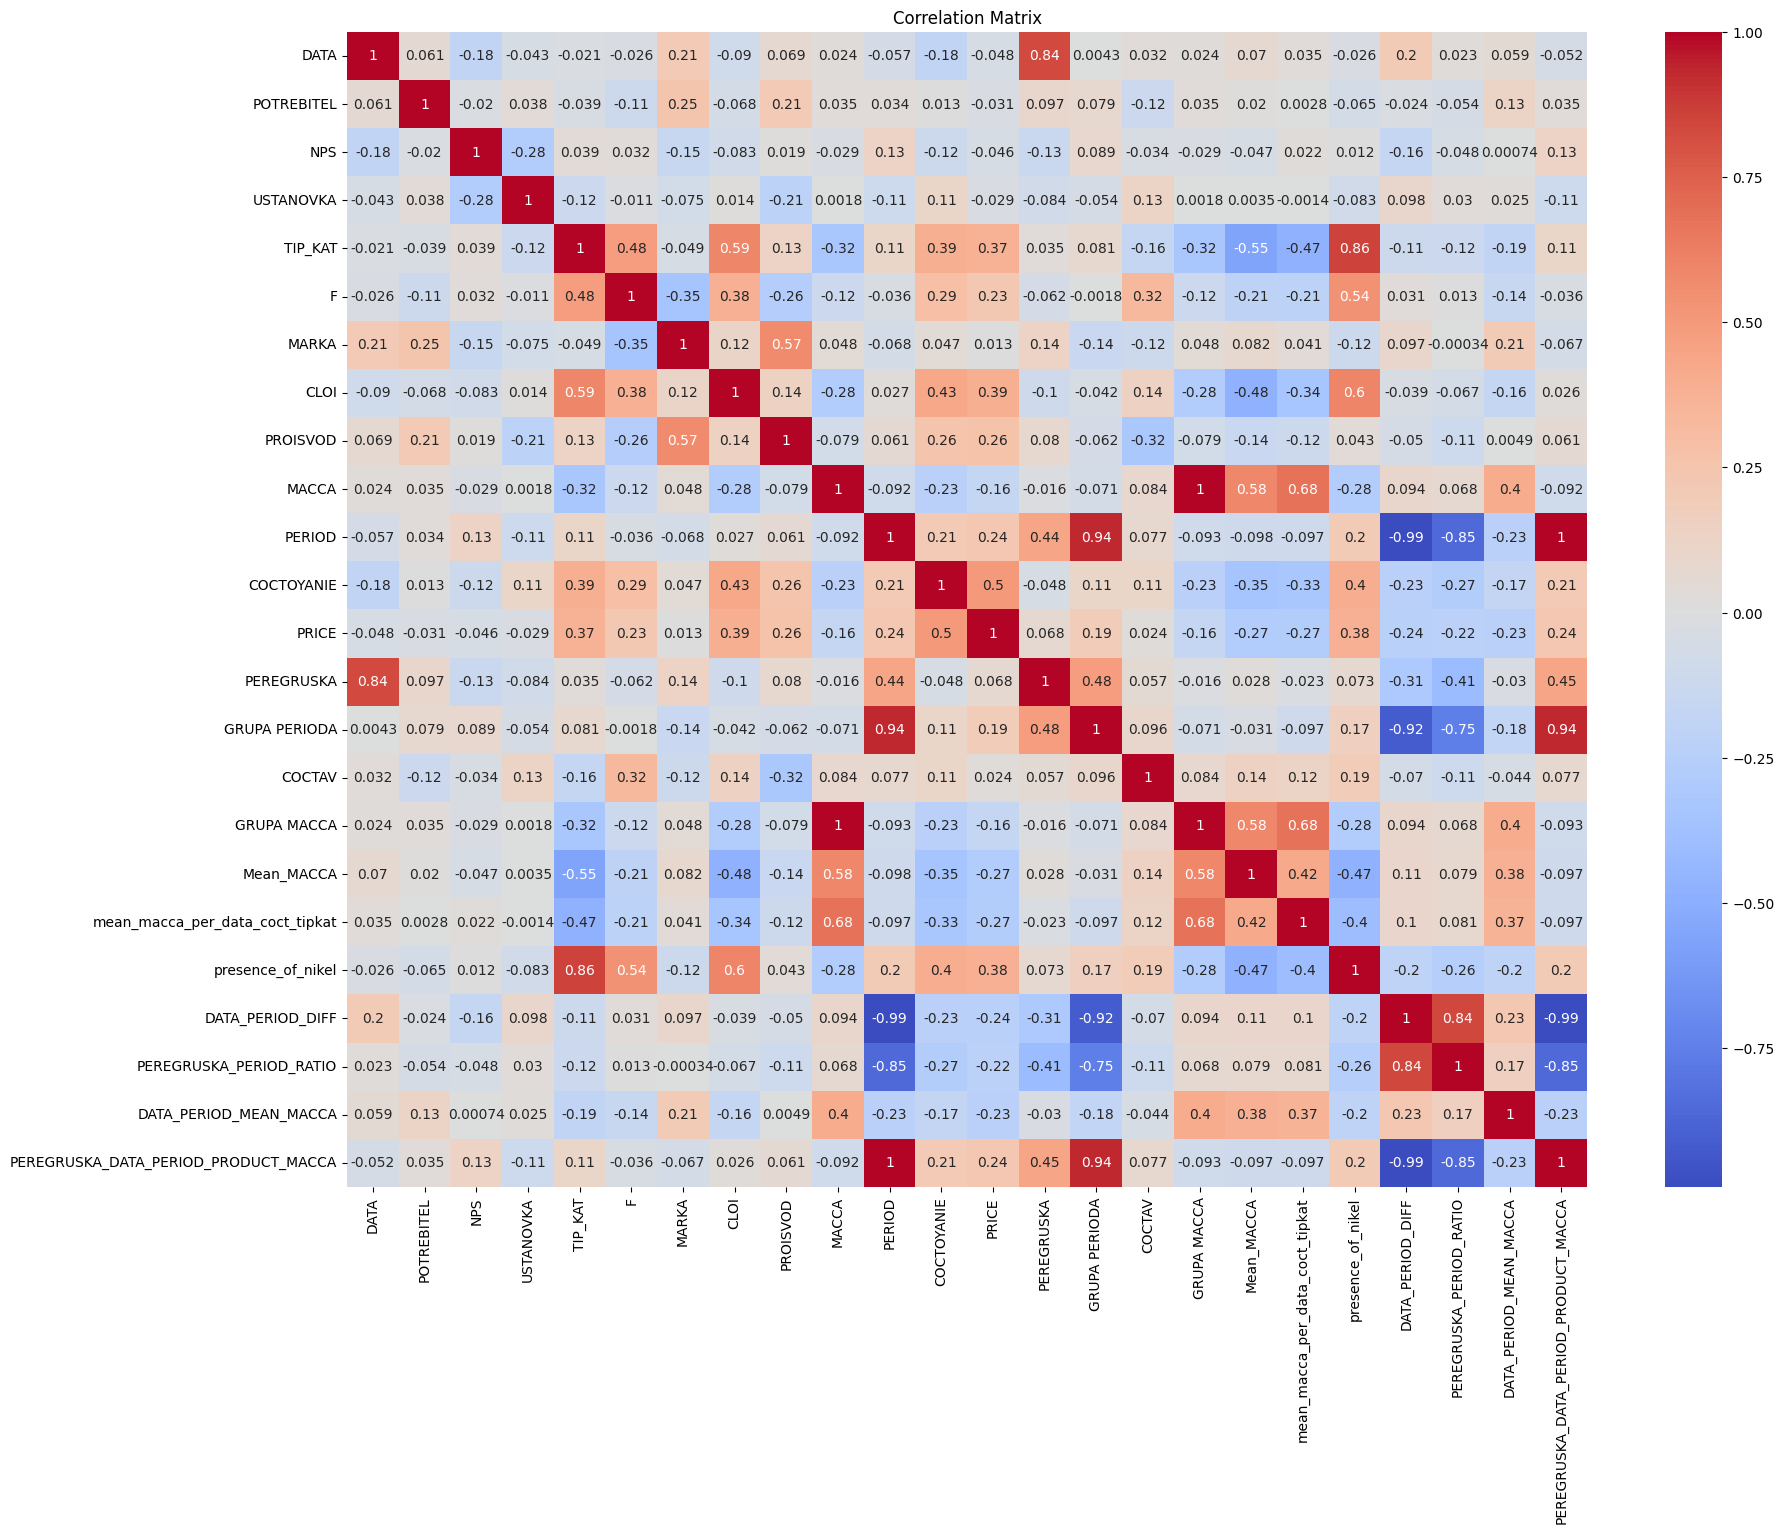

In [ ]:
matri = MatrixCorrelation(DF)
matri.matrix()
matri.graph()

In [ ]:
# Корреляция и сортировка
correlations = DF.corr()['PRICE'].sort_values()
# Отображение
print('Наивысшая позитивная корреляция: n', correlations.tail(15))
print('nНаивысшая негативная корреляция: n', correlations.head(15))

Наивысшая позитивная корреляция: n POTREBITEL                             -0.031
USTANOVKA                              -0.029
MARKA                                   0.013
COCTAV                                  0.024
PEREGRUSKA                              0.068
GRUPA PERIODA                           0.192
F                                       0.230
PERIOD                                  0.235
PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA    0.235
PROISVOD                                0.263
TIP_KAT                                 0.375
presence_of_nikel                       0.384
CLOI                                    0.394
COCTOYANIE                              0.500
PRICE                                   1.000
Name: PRICE, dtype: float64
nНаивысшая негативная корреляция: n Mean_MACCA                        -0.274
mean_macca_per_data_coct_tipkat   -0.267
DATA_PERIOD_DIFF                  -0.238
DATA_PERIOD_MEAN_MACCA            -0.231
PEREGRUSKA_PERIOD_RATIO           -0.224
GRUPA 

# Обучение модели

1.

In [ ]:
X1 = DF.drop(columns=['PRICE'])
y1 = DF['PRICE']

In [ ]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=70)
random_seed = 70


In [ ]:
# поиск параметрво для градиентного бустинга
#params = find_best_params(X_train, y_train, random_seed)
#params

R^2 score: 0.5790063822125991
MSE на тестовой выборке: 12.783162475461383
RMSE на тестовой выборке: 3.5753548740595504
MAE на тестовой выборке: 2.7540212504069013
MAPE на тестовой выборке: 15.762079302543425
WAPE на тестовой выборке: 15.087771642112319
SMAPE на тестовой выборке: 15.96421288359449


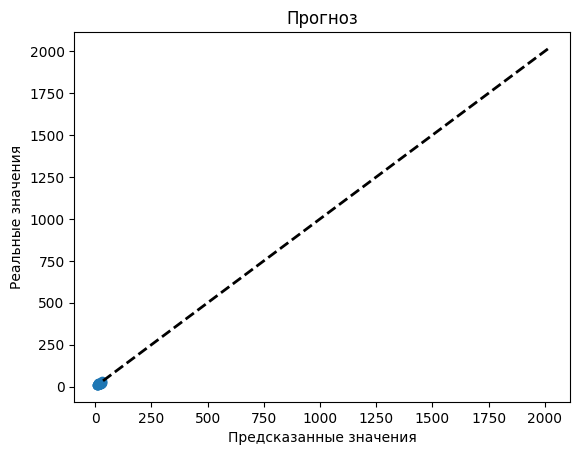

In [ ]:
paramss = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 140, 'random_state': 42, 'reg_alpha': 0.1}
model = xgb.XGBRegressor(**paramss)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
title = 'Прогноз'
my_result(y_test, y_pred, title)

2.

                                 feature  importance
11                            COCTOYANIE       0.492
17       mean_macca_per_data_coct_tipkat       0.108
6                                  MARKA       0.065
22  PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA       0.057
16                            Mean_MACCA       0.050
8                               PROISVOD       0.046
21                DATA_PERIOD_MEAN_MACCA       0.024
5                                      F       0.020
0                                   DATA       0.019
19                      DATA_PERIOD_DIFF       0.018
n Признаков с важностью выше 0.01 =  17


,feature,importance
11,COCTOYANIE,0.492
17,mean_macca_per_data_coct_tipkat,0.108
6,MARKA,0.065
22,PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA,0.057
16,Mean_MACCA,0.050
8,PROISVOD,0.046
21,DATA_PERIOD_MEAN_MACCA,0.024
5,F,0.020
0,DATA,0.019
19,DATA_PERIOD_DIFF,0.018


<Figure size 1200x800 with 0 Axes>

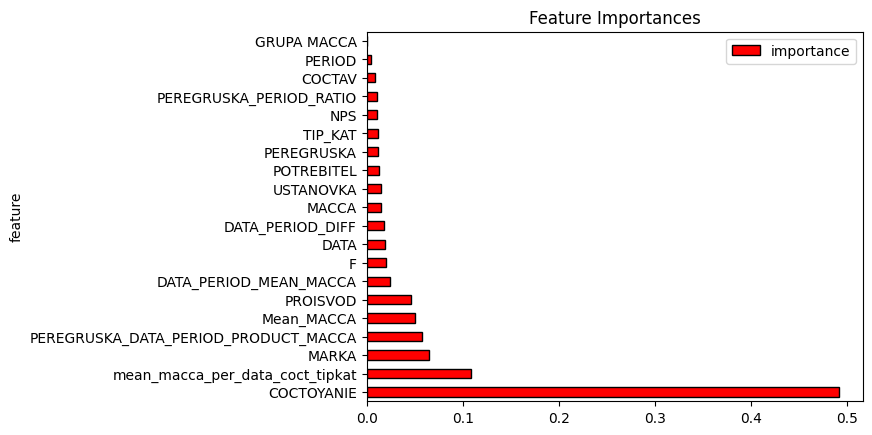

In [ ]:
show_feature_importances(model, X_train.columns)

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

Введите индекс для установки от 0 до 44: 12


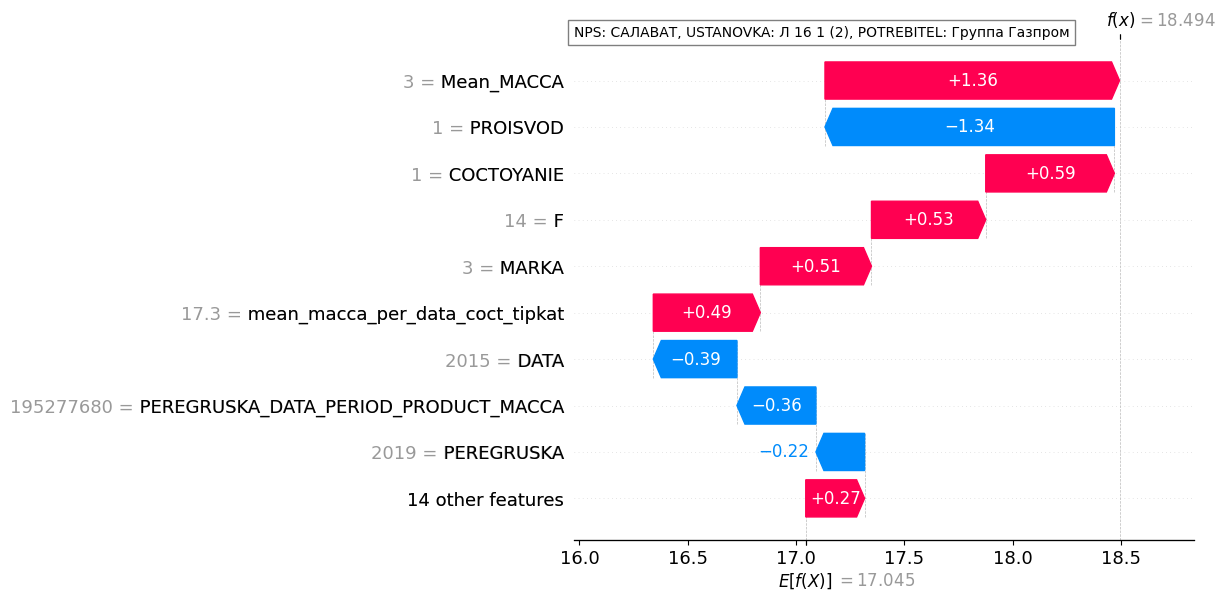

In [ ]:
index = int(input("Введите индекс для установки от 0 до 44: "))
values_under_index_15 = X_test2.loc[index, ['NPS', 'USTANOVKA', 'POTREBITEL']]
legend_text = f"NPS: {values_under_index_15['NPS']}, USTANOVKA: {values_under_index_15['USTANOVKA']}, POTREBITEL: {values_under_index_15['POTREBITEL']}"

waterfall_plot = shap.plots.waterfall(shap_values[index], show=False)

waterfall_plot.text(0, 1, legend_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5), transform=waterfall_plot.transAxes, verticalalignment='bottom')

plt.show()


In [ ]:
shap.plots.initjs()
shap.plots.force(shap_values[index])

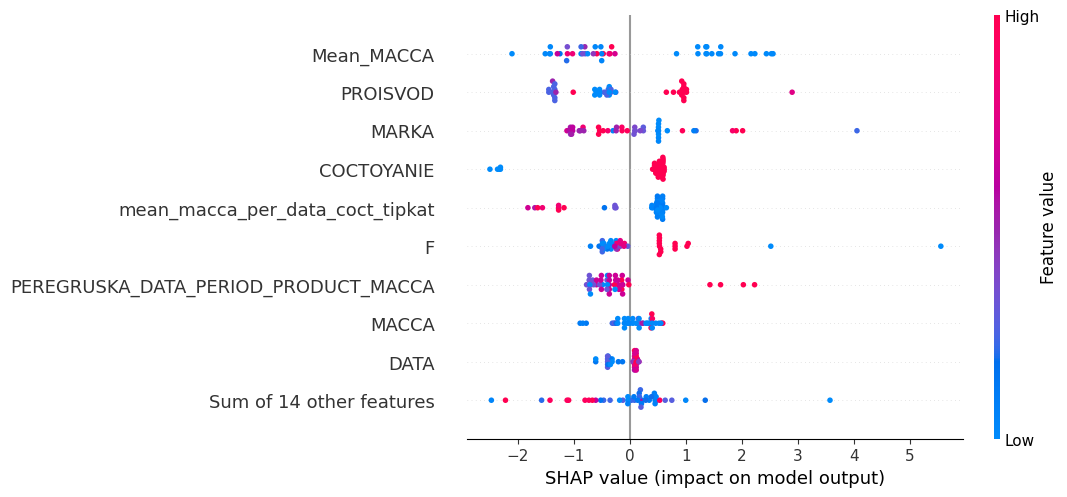

In [ ]:
shap.plots.beeswarm(shap_values)

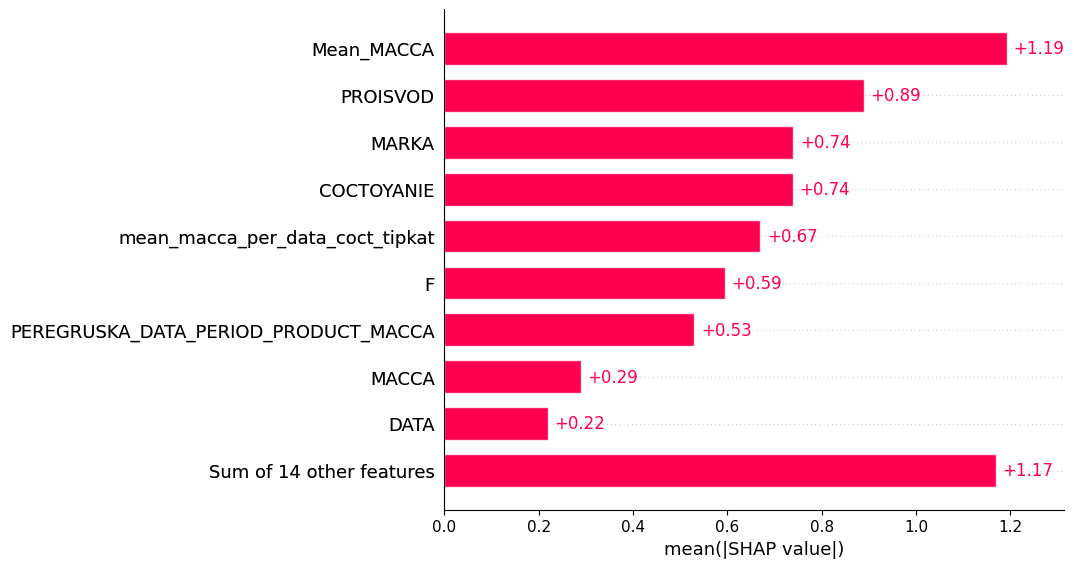

In [ ]:
shap.plots.bar(shap_values)

# Прогноз

1.

In [ ]:
#таблица для предикта
empty_price_table_generator = EmptyPriceTableGenerator(DF)
empty_price_table = empty_price_table_generator.generate_empty_price_table()

with pd.option_context('display.max_columns', None):
    display(empty_price_table)


,DATA,POTREBITEL,NPS,USTANOVKA,TIP_KAT,F,MARKA,CLOI,PROISVOD,MACCA,PERIOD,COCTOYANIE,PEREGRUSKA,GRUPA PERIODA,COCTAV,GRUPA MACCA,Mean_MACCA,mean_macca_per_data_coct_tipkat,presence_of_nikel,DATA_PERIOD_DIFF,PEREGRUSKA_PERIOD_RATIO,DATA_PERIOD_MEAN_MACCA,PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA
133,2019,4,0,34,2,10,0,1,5,110.200,5.000,1,2023,72,2,111,110.200,30.661,1,1958,33.717,35.838,244944840
133,2020,4,0,34,2,10,0,1,5,110.200,5.000,1,2023,72,2,111,110.200,30.661,1,1958,33.717,35.838,244944840
133,2021,4,0,34,2,10,0,1,5,110.200,5.000,1,2023,72,2,111,110.200,30.661,1,1958,33.717,35.838,244944840
133,2022,4,0,34,2,10,0,1,5,110.200,5.000,1,2023,72,2,111,110.200,30.661,1,1958,33.717,35.838,244944840
133,2023,4,0,34,2,10,0,1,5,110.200,5.000,1,2023,72,2,111,110.200,30.661,1,1958,33.717,35.838,244944840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2029,5,4,37,2,4,72,1,4,3.900,3.000,1,2026,48,2,4,3.050,2.475,1,1987,56.278,48.083,147549528
211,2030,5,4,37,2,4,72,1,4,3.900,3.000,1,2026,48,2,4,3.050,2.475,1,1987,56.278,48.083,147549528
211,2031,5,4,37,2,4,72,1,4,3.900,3.000,1,2026,48,2,4,3.050,2.475,1,1987,56.278,48.083,147549528
211,2032,5,4,37,2,4,72,1,4,3.900,3.000,1,2026,48,2,4,3.050,2.475,1,1987,56.278,48.083,147549528


2.

In [ ]:
y_future_price = model.predict(empty_price_table)

In [ ]:
empty_price_table['y_future_price'] = y_future_price
empty_price_table.rename(columns={'y_future_price': 'PRICE'}, inplace=True)
cols = empty_price_table.columns.tolist()
cols.insert(1, cols.pop(cols.index('PRICE')))
price = empty_price_table.reindex(columns=cols)

In [ ]:
price.drop(['GRUPA PERIODA', 'COCTAV','GRUPA MACCA', 'Mean_MACCA', 'mean_macca_per_data_coct_tipkat', 'presence_of_nikel', 'DATA_PERIOD_DIFF', 'PEREGRUSKA_PERIOD_RATIO', 'DATA_PERIOD_MEAN_MACCA', 'PEREGRUSKA_DATA_PERIOD_PRODUCT_MACCA'], axis=1, inplace=True)
for col in text_categor_cols:
    price[col] = label_encoders[col].inverse_transform(price[col])
with pd.option_context('display.max_columns', None):
    display(price)

,DATA,PRICE,POTREBITEL,NPS,USTANOVKA,TIP_KAT,F,MARKA,CLOI,PROISVOD,MACCA,PERIOD,COCTOYANIE,PEREGRUSKA
133,2019,40.943,Роснефть,АНГАРСКИЙ,Л 35 11/1000,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
133,2020,40.943,Роснефть,АНГАРСКИЙ,Л 35 11/1000,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
133,2021,40.943,Роснефть,АНГАРСКИЙ,Л 35 11/1000,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
133,2022,40.943,Роснефть,АНГАРСКИЙ,Л 35 11/1000,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
133,2023,40.943,Роснефть,АНГАРСКИЙ,Л 35 11/1000,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2029,22.685,Сургутнефтегаз,КИНЕФ,ЛГ 24 7 2 блок,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
211,2030,22.685,Сургутнефтегаз,КИНЕФ,ЛГ 24 7 2 блок,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
211,2031,22.685,Сургутнефтегаз,КИНЕФ,ЛГ 24 7 2 блок,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
211,2032,22.685,Сургутнефтегаз,КИНЕФ,ЛГ 24 7 2 блок,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026


3.

# **Итоговая таблица**

In [ ]:
price.set_index('USTANOVKA', inplace=True)

with pd.option_context('display.max_columns', None):
    display(price)

,DATA,PRICE,POTREBITEL,NPS,TIP_KAT,F,MARKA,CLOI,PROISVOD,MACCA,PERIOD,COCTOYANIE,PEREGRUSKA
USTANOVKA,,,,,,,,,,,,,
Л 35 11/1000,2019,40.943,Роснефть,АНГАРСКИЙ,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
Л 35 11/1000,2020,40.943,Роснефть,АНГАРСКИЙ,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
Л 35 11/1000,2021,40.943,Роснефть,АНГАРСКИЙ,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
Л 35 11/1000,2022,40.943,Роснефть,АНГАРСКИЙ,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
Л 35 11/1000,2023,40.943,Роснефть,АНГАРСКИЙ,NiMo,Saturation,3D DOS 30,Grading,UOP,110.200,5.000,1,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ЛГ 24 7 2 блок,2029,22.685,Сургутнефтегаз,КИНЕФ,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
ЛГ 24 7 2 блок,2030,22.685,Сургутнефтегаз,КИНЕФ,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
ЛГ 24 7 2 блок,2031,22.685,Сургутнефтегаз,КИНЕФ,NiMo,HDM/HDS,ТК 711,Grading,HALDOR TOPSOE,3.900,3.000,1,2026
